# DeepVoxNet 2: Yet another CNN framework

# 1. Introduction
Yes, we are introducing yet another CNN framework.
However, to the best of our knowledge there are no libraries that stay true to the aspects that we introduced in Section 1 in the previous chapter.
The main driver behind the creation of DeepVoxNet2 (DVN2) was that we wanted to make something that gives insights, rather than something that is super efficient or fully self-configuring (e.g. nnU-Net).

## 1.1 Installation
The DVN2 repository can be installed as a Python library such that all dependencies are also configured correctly.
In fact, even when you do not want to use the functionalities of DVN2 explicitly, installing it will provide users with a complete and working Python environment for doing medical image analysis in general.
As of now, it is best to add DVN2 to an empty Python 3.9 environment, e.g. using the Anaconda package manager to first create and activate such an environment via:
```
conda create --name dvn2env python=3.9
conda activate dvn2env
```
Once you have activated your Python 3.9 environment correctly, there are two options to install DVN2 together with al its dependencies, and as a result make your environment medical image analysis proof:

- First cloning or downloading the repository and then via:
```
pip install -e /path/to/deepvoxnet2
```
- Installing it directly from Github via:
```
pip install git+https://github.com/JeroenBertels/deepvoxnet2
```

The first method is particularly useful if you want to develop and contribute to the DVN2 library yourself.
To upgrade your installation using the first method, simply download the latest version and repeat the process or ```git pull``` the new version.
When using the second method simply repeat the command but add the ```--upgrade``` flag.
You can also install or revert to a specific version of DVN2. In that case, append ```@version_tag``` (e.g. *\@deepvoxnet-2.12.1*) to the paths in the above commands.
Some functions require the SimpleITK and SimpleElastix software to be installed. To install these packages, please append the paths in the above commands with ```[sitk]```.
These are not installed by default because they are only available for a limited number of operating systems.

## 1.2 Schematic overview [under construction]
Not necessary to make a difference between X and Y; they can be represented using the same abstraction.
Notation X and Y simply to denote input and output, but could have been more than one or two also.
Remember the sets S that contain data pairs (X,Y).
Instead of representing and loading these as simple lists of data pairs, DVN2 does this in a more structured manner.
Thus, a data pairs could be list of Samples or a record; just a matter of representation.
Typically sampling functions first sample, then map.
Converting one data pair in another is done using Transformers.
A Creator is a higher abstract Class that make a combination of Transormers a true Transformer network (e.g. giving names, possibility to print summary, store).
Then also DvnModel made for efficient experimenting.

# 2. The Sample object
One of the core objects of DVN2 is the Sample object.
In line with the definitions of $X$ and $Y$ from the previous chapter, the Sample represents an array with a batch axis $\mathcal{B}$, a spatial axis $\mathcal{I}$ and a feature axis $\mathcal{F}$.
The spatial axis itself is 3D, hence the Sample object is a 5D array of size B x $\mathrm{I}_0$ x $\mathrm{I}_1$ x $\mathrm{I}_2$ x F.
Different from the standard Numpy array, the Sample object also has an affine attribute.
This affine attribute stores the voxel-to-world transformation matrix for each batch element.
As a result, the affine is a 3D array of size B x 4 x 4, thus assuming the same voxel-to-world transformation for each feature $f$ given a batch element $b$.

In [1]:
import numpy as np
from deepvoxnet2.components.sample import Sample

array_of_ones = np.ones((2, 100, 100, 3))
sample_of_ones = Sample(array_of_ones, affine=None)
print(sample_of_ones.shape)
print(sample_of_ones.affine)

(1, 2, 100, 100, 3)
[[[1. 0. 0. 0.]
  [0. 1. 0. 0.]
  [0. 0. 1. 0.]
  [0. 0. 0. 1.]]]


It should be clear that upon creation the Sample object makes sure the underlying array is 5D and that an affine is specified.
Therefore, be careful and be specific.
It is best practice to always fully provide the 5D array and affine yourself to avoid unexpected behavior.
In that sense, when you are indeed working with only two spatial dimensions, it would be straightforward to set the fourth dimension of the Sample object as the singleton dimension.

In [2]:
default_affine = np.eye(4)
sample_of_ones = Sample(array_of_ones[:, :, :, None, :], affine=np.stack([default_affine] * 2, axis=0))
print(sample_of_ones.shape)
print(sample_of_ones.affine)

(2, 100, 100, 1, 3)
[[[1. 0. 0. 0.]
  [0. 1. 0. 0.]
  [0. 0. 1. 0.]
  [0. 0. 0. 1.]]

 [[1. 0. 0. 0.]
  [0. 1. 0. 0.]
  [0. 0. 1. 0.]
  [0. 0. 0. 1.]]]


It is possible that you have a medical image, for example in Nifti format, and that you want to convert this into a Sample object.
In this case, you can load the image and use the internal data and affine to create the Sample.
Below we do this for the FLAIR image and the ground truth whole tumor segmentation (GT) of the first subject.
It should not be surprising that both the FLAIR and GT are equal in size and have the same voxel-to-word transformation.

In [3]:
import os
import nibabel as nib
from deepvoxnet2 import DEMO_DIR  # modify the DEMO_DIR accordingly

flair_path = os.path.join(DEMO_DIR, "brats_2018", "case_0", "FLAIR.nii.gz")
flair_image = nib.load(flair_path)
print(flair_image.shape)
print(flair_image.affine)
flair_sample = Sample(flair_image.get_fdata()[None, ..., None], affine=flair_image.affine[None, ...])
print(flair_sample.shape)
print(flair_sample.affine)
gt_path = os.path.join(DEMO_DIR, "brats_2018", "case_0", "GT_W.nii.gz")
gt_image = nib.load(gt_path)
gt_sample = Sample(gt_image.get_fdata()[None, ..., None], affine=gt_image.affine[None, ...])
print(gt_sample.shape)
print(gt_sample.affine)

(240, 240, 155)
[[ -1.  -0.  -0.   0.]
 [ -0.  -1.  -0. 239.]
 [  0.   0.   1.   0.]
 [  0.   0.   0.   1.]]
(1, 240, 240, 155, 1)
[[[ -1.  -0.  -0.   0.]
  [ -0.  -1.  -0. 239.]
  [  0.   0.   1.   0.]
  [  0.   0.   0.   1.]]]
(1, 240, 240, 155, 1)
[[[ -1.  -0.  -0.   0.]
  [ -0.  -1.  -0. 239.]
  [  0.   0.   1.   0.]
  [  0.   0.   0.   1.]]]


It should be clear that a Sample object is not so different from a Numpy array.
If you do not care about the spatiality of the data, you can always use the default affine and ignore it.
Let us already define a visualization function that will become handy later on in this tutorial.
For a list of Sample objects, it will simply depict for the first batch element and first feature the middle slice of each Sample in the list.

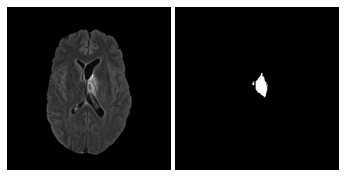

In [4]:
from matplotlib import pyplot as plt

def visualize_list_of_samples(list_of_samples):
    n_cols = len(list_of_samples)
    fig, axs = plt.subplots(1, n_cols, figsize=(n_cols * 3 * list_of_samples[0].shape[1] / 240, 3 * list_of_samples[0].shape[1] / 240))
    axs = [axs] if n_cols == 1 else axs
    for i, sample in enumerate(list_of_samples):
        axs[i].imshow(sample[0, :, :, sample.shape[3] // 2, 0].T, cmap="gray"), axs[i].axis("off")

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

visualize_list_of_samples((flair_sample, gt_sample))

# 3. Organizing the data
Now that we have defined the Sample object, which can represent any $x$ or $y$, we could potentially start constructing multiple sets of data pairs, e.g. $S'$, $S''$, etc.
In fact, we could do so by simply having a list of lists of Sample objects.
If we only had one data pair, this would look as follows:

In [5]:
simple_set = [(flair_sample, gt_sample)]

However, such a representation is nor valid, nor feasible due to various reasons.
Remember that the set $\mathcal{S}'$ represents pairs of native data, e.g. samples drawn from the distribution ($\mathcal{X},\mathcal{Y}$).
For large datasets or large data it would become impossible to load everything into memory at once.
Furthermore, the subsequently derived sets $\mathcal{S''}$, etc, are in fact (practically) infinite, e.g. data augmentation, and thus impossible to represent with a simple list.
We therefore chose to only organize the native data, i.e. the set $\mathcal{S}'$, in a more structured manner.
The other sets are represented implicitly by defining the sampling functions $s''$, etc (see Sect. 5 and 6).

To organize our data we have created a hierarchical structure of dictionaries: Mirc > Dataset > Case > Record > Modality.
When creating instantiations of a Dataset, Case, Record or Modality, we will need to specify an ID.
As a result, each dictionary consists of key-value pairs, with the keys corresponding to the lower level object's IDs.
The purpose of the Mirc object is to group multiple Dataset objects and provide the user with higher-level functionalities of which we will explain a few at the end of this section.

## 3.1 The Modality object
Starting from the lowest level, a Modality is simply something that returns a Sample object when ```load()``` is called.
This is useful because when having a large dataset, it is not possible to load every image at the same time, and thus the ```load``` method provides a way to only create a Sample object from it when needed.
Note that the Modality is an abstract class, and to really make use of the aforementioned feature, we should e.g. use the NiftiFileModality.
When the dataset is small, or for e.g. metadata such as age, it could be more efficient or appropriate to load everything to disk and use the NiftiModality or ArrayModality instead.
Other Modality subtypes that are readily available are ImageFileModality and ImageFileMultiModality.
These use the Image library to load 2D images from disk (e.g. PNG, JPG) and convert them to 5D correctly (setting the fourth dimension as the singleton dimension as mentioned before).

In [6]:
from deepvoxnet2.components.mirc import NiftiFileModality, NiftiModality, ArrayModality

flair_modality = NiftiFileModality("flair", file_path=flair_path)
flair_modality_ = NiftiModality("flair", nifty=flair_image)
flair_modality__ = ArrayModality("flair", array=flair_image.get_fdata(), affine=flair_image.affine)
assert np.array_equal(flair_modality.load(), flair_modality_.load())
assert np.array_equal(flair_modality.load(), flair_modality__.load())
print(flair_modality.load().shape)
print(flair_modality.load().affine)
gt_modality = NiftiFileModality("gt", file_path=flair_path)
metadata_modality = ArrayModality("age", array=45)  # just an example how we could make a metadata Sample, e.g. of age
print(metadata_modality.load().shape)
print(metadata_modality.load().affine)

(1, 240, 240, 155, 1)
[[[ -1.  -0.  -0.   0.]
  [ -0.  -1.  -0. 239.]
  [  0.   0.   1.   0.]
  [  0.   0.   0.   1.]]]
(1, 1, 1, 1, 1)
[[[1. 0. 0. 0.]
  [0. 1. 0. 0.]
  [0. 0. 1. 0.]
  [0. 0. 0. 1.]]]


Notice that we have created a "flair" Modality in three ways, but that the final Sample objects are similar.
As such, always think of what is the most efficient way to represent a certain data type in your situation.

## 3.2 The Record, Case and Dataset objects
To create pairs of data, we should group multiple Modality objects under a so-called Record.
On its turn, multiple Record objects need to be grouped under a Case object.
The idea between the existence of both a Case and a Record is that there might be multiple *records* (e.g. observations) for a certain *case* (e.g. a subject).
Imagine that you have multiple experts annotating the same subject or that you have multiple parts of the body scanned separately.
Finally, cases should be grouped under a Dataset object.
Let's construct a tumor dataset based on data of 10 subjects from BRATS 2018 below.

In [7]:
from deepvoxnet2.components.mirc import Dataset, Case, Record

def get_tumor_dataset(dataset_id, case_indices):
    tumor_dataset = Dataset(dataset_id)
    for i in case_indices:
        subject = Case(f"subject_{i}")
        for j in range(1):  # we only have a single observation for each subject here
            observation = Record(f"observation_{j}")
            flair_modality = NiftiFileModality("flair", file_path=os.path.join(DEMO_DIR, "brats_2018", f"case_{i}", "FLAIR.nii.gz"))
            gt_modality = NiftiFileModality("gt", file_path=os.path.join(DEMO_DIR, "brats_2018", f"case_{i}", "GT_W.nii.gz"))
            age_modality = ArrayModality("age", np.random.randint(20, 80))
            observation.add(flair_modality)
            observation.add(gt_modality)
            observation.add(age_modality)
            subject.add(observation)

        tumor_dataset.add(subject)

    return tumor_dataset

tumor_dataset = get_tumor_dataset("train_dataset", range(8))
print(f"{tumor_dataset.dataset_id} contains {len(tumor_dataset)} cases:")
for case_id in tumor_dataset:
    print(f"\t{case_id} contains {len(tumor_dataset[case_id])} records:")
    for record_id in tumor_dataset[case_id]:
        print(f"\t\t{record_id} contains {len(tumor_dataset[case_id][record_id])} modalities:")
        for modality_id in tumor_dataset[case_id][record_id]:
            print(f"\t\t\t{modality_id}")

train_dataset contains 8 cases:
	subject_0 contains 1 records:
		observation_0 contains 3 modalities:
			age
			flair
			gt
	subject_1 contains 1 records:
		observation_0 contains 3 modalities:
			age
			flair
			gt
	subject_2 contains 1 records:
		observation_0 contains 3 modalities:
			age
			flair
			gt
	subject_3 contains 1 records:
		observation_0 contains 3 modalities:
			age
			flair
			gt
	subject_4 contains 1 records:
		observation_0 contains 3 modalities:
			age
			flair
			gt
	subject_5 contains 1 records:
		observation_0 contains 3 modalities:
			age
			flair
			gt
	subject_6 contains 1 records:
		observation_0 contains 3 modalities:
			age
			flair
			gt
	subject_7 contains 1 records:
		observation_0 contains 3 modalities:
			age
			flair
			gt


## 3.3 The Mirc object
When we have build our dataset, we can group it, optionally with other datasets, into a Mirc object.
The Mirc object is a powerful tool to get a complete overview of all your data.
Calling ```get_dataset_ids()```, ```get_case_ids()```, ```get_record_ids()``` or ```get_modality_ids()``` you can get a quick overview on what data is available in your Mirc object.
You can also calculate the mean and standard deviation for a particular modality by using the ```mean_and_std``` method.
The ```inspect``` method is particularly useful to check multiple modalities for spatial consistency and get an overview of the distribution of voxel sizes and other spatial characteristics of your data.
Using the ```get_df``` method it is possible to acquire a Pandas DataFrame such that you could do other types of analyses or inspections.
This is particularly useful if you want to inspect distributions of non-imaging data, such as age.

['train_dataset', 'val_dataset']
['subject_0', 'subject_1', 'subject_2', 'subject_3', 'subject_4', 'subject_5', 'subject_6', 'subject_7', 'subject_8', 'subject_9']
['observation_0']
['age', 'flair', 'gt']
(26.520628640232975, 66.88867846141157)
Total number of different dataset ids: 2
Total number of different case ids: 10
Total number of different record ids: 1
Total number of different modality ids: 2


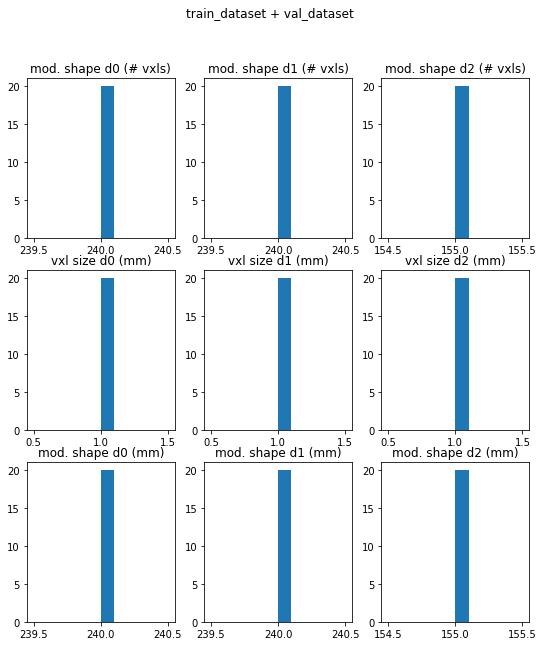

Mean and standard deviation of 'flair': (26.520628640232975, 66.88867846141157)
Mean and standard deviation of 'gt': (0.013233926971326165, 0.11427506354513185)


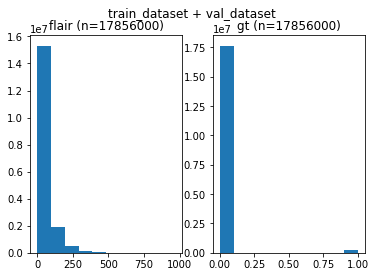

None
modality_id                                      age
dataset_id    case_id   record_id                   
train_dataset subject_0 observation_0  [[[[[74.]]]]]
              subject_1 observation_0  [[[[[54.]]]]]
              subject_2 observation_0  [[[[[65.]]]]]
              subject_3 observation_0  [[[[[29.]]]]]
              subject_4 observation_0  [[[[[38.]]]]]
              subject_5 observation_0  [[[[[47.]]]]]
              subject_6 observation_0  [[[[[48.]]]]]
              subject_7 observation_0  [[[[[60.]]]]]
val_dataset   subject_8 observation_0  [[[[[56.]]]]]
              subject_9 observation_0  [[[[[23.]]]]]


In [8]:
from deepvoxnet2.components.mirc import Mirc

train_tumor_dataset = tumor_dataset
val_tumor_dataset = get_tumor_dataset("val_dataset", range(8, 10))
my_mirc = Mirc(train_tumor_dataset, val_tumor_dataset)
print(my_mirc.get_dataset_ids())
print(my_mirc.get_case_ids())
print(my_mirc.get_record_ids())
print(my_mirc.get_modality_ids())
print(my_mirc.mean_and_std("flair", n=2))  # computing the mean and standard deviation using all your images might be too expensive, therefore limit the number of images used setting the n option
print(my_mirc.inspect(["flair", "gt"], ns=[2, 2]))
print(my_mirc.get_df("age"))

You might have noticed that we already gave the previously created ```tumor_dataset``` the ID *train_dataset*.
In a similar manner, we have now also created a *val_dataset*.
In the aforementioned usage example of the Mirc object we have grouped both our training and our validation set under one Mirc object.
Keep in mind that this was just for illustration purposes.
It is always a good idea to keep the two separate.

# 4. Data sampling
Once that we have defined the set $\mathcal{S'}$, e.g. by means of a Mirc object containing Record objects at its lowest level or simply a list of lists of Sample objects, we can start thinking about the sampling functions, e.g. the function $s''$ that produces the learning set $\mathcal{S''}=\mathcal{S}$ from $\mathcal{S'}$.
It turns out that we can often view any sampling function, that goes from one set of data pairs to another, as something that first samples a data pair and then applies some form of data transformation to it creating zero, one or more transformed data pairs.
In this section, we will discuss the first part of the sampling function, more specifically the Sampler object.
For now, you can view the Sampler object as having an internal list of objects that we can index to retrieve the object.
While the retrieved object could be a Record object or a list of Sample objects, we chose to define it as a new object, i.e. the Identifier object.

## 4.1 The Identifier object
Actually, let us start by saying that the Identifier object could be any object, since we could define the word *sampling* as retrieving *something* from a list.
In our specific use case, the returned Identifier object will be used by the data transformation function (see Sect. 5), and thus should contain all information that is necessary to do the tranformation.
Letting the Identifier represent a list of Samples or a Record would be sufficient in that case.
However, if representing a Record, the Identifier has no notion from which Dataset or which Case it was from.
For this purpose, if we want to keep track of this additional information we could wrap a Record as a MircIdentifier.

In [9]:
from deepvoxnet2.components.sampler import MircIdentifier

record_identifier = MircIdentifier(my_mirc, dataset_id="train_dataset", case_id="subject_0", record_id="observation_0")
print(record_identifier())
for modality_id in record_identifier.mirc[record_identifier.dataset_id][record_identifier.case_id][record_identifier.record_id]:
    print(modality_id)

('train_dataset', 'subject_0', 'observation_0', None)
age
flair
gt


## 4.2 The Sampler object
As mentioned before, we chose to define a Sampler as a rather simple object, more specifically a list of Identifier objects, but with some additional functionalities.
An important functionality is the ability to *shuffle* its internal list of Identifier objects by calling ```randomize()```.
Whether this call will do anything depends on the value of the ```shuffle``` option when you create the Sampler, which defaults to ```False```.
The shuffling itself is a new permutation of the list of Identifiers, potentially with replacement according to the probability density specified using the ```weights``` option.
In DVN2 you can use the MircSampler to convert a Mirc object to a Sampler of MircIdentifiers.
Depending on the ```mode``` option, either ```"per_case"``` or ```"per_record"```, the internal list of MircIdentifiers and its shuffling will be different.
Using ```mode="per_case"``` the size of the list will be the number of Case objects in the Mirc object, thus with Record objects selected uniformly across all Case objects.
Using ```mode="per_record"``` the size of the list will be the number of Record objects in the Mirc object, thus with Records selected uniformly across all Record objects.

In [10]:
from deepvoxnet2.components.sampler import Sampler, MircSampler

a_simple_sampler = Sampler([1, 2, 3, 4, 5], shuffle=True, weights=[1, 1, 10, 1, 1])
for i in range(5):
    print([a_simple_sampler[j] for j in range(len(a_simple_sampler))])
    a_simple_sampler.randomize()

my_mirc_sampler = MircSampler(my_mirc, mode="per_case", shuffle=False)  # shuffle=False for visualization purposes later
for i in range(5):
    print([my_mirc_sampler[j].case_id for j in range(len(my_mirc_sampler))])
    my_mirc_sampler.randomize()

[3, 3, 3, 3, 3]
[3, 3, 1, 2, 3]
[3, 3, 2, 1, 3]
[5, 5, 3, 3, 3]
[3, 3, 3, 3, 4]
['subject_0', 'subject_1', 'subject_2', 'subject_3', 'subject_4', 'subject_5', 'subject_6', 'subject_7', 'subject_8', 'subject_9']
['subject_0', 'subject_1', 'subject_2', 'subject_3', 'subject_4', 'subject_5', 'subject_6', 'subject_7', 'subject_8', 'subject_9']
['subject_0', 'subject_1', 'subject_2', 'subject_3', 'subject_4', 'subject_5', 'subject_6', 'subject_7', 'subject_8', 'subject_9']
['subject_0', 'subject_1', 'subject_2', 'subject_3', 'subject_4', 'subject_5', 'subject_6', 'subject_7', 'subject_8', 'subject_9']
['subject_0', 'subject_1', 'subject_2', 'subject_3', 'subject_4', 'subject_5', 'subject_6', 'subject_7', 'subject_8', 'subject_9']


It might look strange that a Sampler has a finite internal list and is not just something that *generates* Identifier objects indefinitely or until completion.
However, using this abstraction it is easier to keep track of having seen all data pairs at least once before shuffling, etc.

# 5. Data transformation
Now that we have selected a data pair from our set $S'$, e.g. as a MircIdentifier using a MircSampler constructed from a Mirc object, we want to transform this data pair into zero, one or more transformed data pairs.
To do so, DVN2 uses Transformer objects.
To achieve complex transformations, a network of Transformer objects can be constructed and wrapped as a Creator object to unlock higher-level functionalities.

To start, we can view a Transformer object as having an input and an output, both using the simplest representation of a data pair, i.e. a list of Sample objects.
Furthermore, from its input it can generate zero, one or more (potentially infinite) outputs.
What transformation and how many exactly depends on the type of Transformer and what options you specify.
Typically, the input of one Transformer is the output of another.

## 5.1 The InputTransformer object
While all Transformers work as input-to-output and use a list-of-Sample-objects representation, there is one type of Transformer that is slightly different: the InputTransformer.
In a sense, the InputTransformer has no input and thus can not be connected to the output of another Transformer.
They serve as the start of your Transformer network and exist to convert any type of Identifier into a list of Sample objects.
It is this property that makes it possible to work with a more structured form of your dataset, using any type of Identifier produced by the Sampler.
In fact, the sole thing that must be foreseen is a dedicated InputTransformer that knows how to convert the Identifier to a list of Samples that it will present at its output.
When making use of MircIdentifiers, we can use the MircInput InputTransformer.
When making use of a list of Samples already, we should use the SampleInput InputTransformer.
Typically for any InputTransformer, is that we need to load the Identifier into the Transformer *manually* by using its ```load``` method.

Evaluation 0:


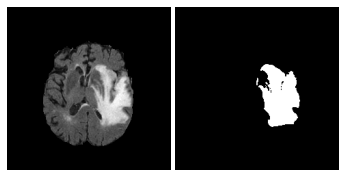

Generation stopped after n=1 evaluations


In [11]:
from deepvoxnet2.components.transformers import _MircInput

mirc_input = _MircInput(["flair", "gt"], n=1)  # the use of _MircInput(...) is for illustrative purposes only
mirc_input.load(my_mirc_sampler[1])  # here we do this manually, but usually we use the higher-level Creator, which we can also use for debugging
x_y = mirc_input()  # normally we will use MircInput(...) instead, which does _MircInput(...)() in one go

def visualize_transformer_output(transformer_output):
    for i in range(100):
        try:
            transformer_output_i = transformer_output.eval()
            print(f"Evaluation {i}:")
            visualize_list_of_samples(transformer_output_i)

        except StopIteration:
            print(f"Generation stopped after n={i} evaluations")
            break

visualize_transformer_output(x_y)

In the above example, the InputTransformer ran out of generating new data pairs after one iteration.
In fact, by setting the ```n``` option differently (```n=1``` by default for most Transformers), you can let the Transformer generate n outputs from one input.

## 5.2 The Creator object
Suppose we not only wanted to load the Identifier, but also wanted to Transform it, e.g. by flipping it laterally.
For this purpose, the returned output of any Transformer, e.g. ```x_y``` in the above code snippet, is a Connection object that can be *connected* to the input of another Transformer.
Without going in too much detail, it is simply a reference to a list of Sample objects at a certain output index of a certain Transformer.
This abstraction allows us to build a network of Transformers.

In [12]:
from deepvoxnet2.components.transformers import Flip

x_y = Flip(flip_probabilities=(0.5, 0, 0), n=4)(x_y)
visualize_transformer_output(x_y)

Generation stopped after n=0 evaluations


Even though we ask to produce a total of N=1\*4=4 data pairs, the generation stops immediately.
This is because we already ran the MircInput until completion.
As soon as the Flip Transformer wants to read the output of the MircInput, the latter will tell it has already been depleted.
To overcome this burden, e.g. when debugging or when the Transormer network has run until completion for Identfier A but we want to run it for Identifier B, we can use the Creator object.
The Creator object has a higher-level view on the Transformer network.
For example, it can find all InputTransformer objects in the Transformer network and can reset the state of all Transformer objects.
Below, we first built the Transformer network form above and wrap it as a Creator.

Evaluation 0:
	Output of Transformer 0:


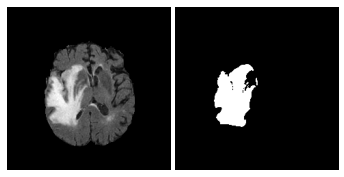

Evaluation 1:
	Output of Transformer 0:


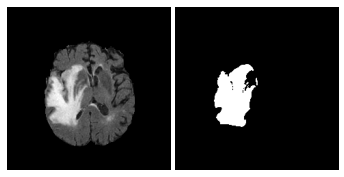

Evaluation 2:
	Output of Transformer 0:


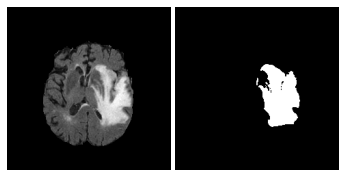

Evaluation 3:
	Output of Transformer 0:


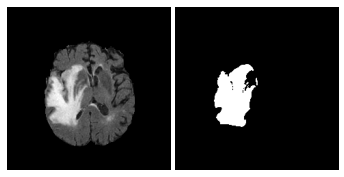

Generation stopped after n=4 evaluations


In [13]:
from deepvoxnet2.components.transformers import MircInput
from deepvoxnet2.components.creator import Creator

x_y = MircInput(["flair", "gt"], n=1, output_shapes=[(1, 240, 240, None, 1), (1, 240, 240, None, 1)])
x_y = Flip(flip_probabilities=(0.5, 0, 0), n=4)(x_y)
x_y_creator = Creator(outputs=[x_y])

def visualize_creator_outputs(creator, identifier):
    i = 0
    for creator_outputs_i in creator.eval(identifier):
        print(f"Evaluation {i}:")
        for j, transformer_output_i in enumerate(creator_outputs_i):
            print(f"\tOutput of Transformer {j}:")
            visualize_list_of_samples(transformer_output_i)

        i += 1

    print(f"Generation stopped after n={i} evaluations")

visualize_creator_outputs(x_y_creator, my_mirc_sampler[1])

Notice how the Creator object has the potential to evaluate the output of multiple Transformer objects at once (we give it a list of Transformer outputs upon creation).
Evaluating the Creator is somewhat different to evaluating a Transformer output as we did before.
When we evaluated a Transformer output, we would have first needed to make sure that all InputTransformer objects had loaded the Identifier.
Then, using ```.eval()``` we simply updated that particular output of that particular Transformer.
However, when using ```.eval(identifier)``` of the Creator object, the Creator will first reset all Transformer objects.
Then, it will load the specified Identifier into all InputTransformer objects it can find in the Transformer network.
Finally, it returns a true generator object that you can run until completion (i.e. as soon as at least one InputTransformer is depleted).

Other useful, higher-level functionalities of the Creator object, is that it traces back which Transformer objects are actually needed to compute the requested Transformer outputs.
As a result, it will simplify the Transformer network internally.
Furthermore, we can save the entire Creator as an object and load it for later use using its static ```save_creator``` and ```load_creator``` methods.
Last but not least, it will give names to the Transformers and you will be able to summarize the network in a printout.

In [14]:
x_y_creator.summary()

____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________
Transformer (type) (n)                             idx        Output shape                                                                Connected to                                                                Extra connected to                                
_MircInput_0 (_MircInput) (1)                      0          [(1, 240, 240, None, 1), (1, 240, 240, None, 1)]                            []                                                                          []                                                
_________________________________________________________________________________________________________________________________________________________________________________________________________________

## 5.3 More complex Transformer networks
The beauty of the Transformer network is that the transformation can become arbitrarily complex, while the construction of it remains relatively simple.
Without describing the functioning of all available Transformer objects, there are a couple of intricacies that are still useful to explain.

The first thing has to do with the data pair, i.e. a list of Sample objects.
It is important to not view this as a pair, but as a list containing one or more Sample objects.
When flowing through the Transformer network, this pair does not need to remain intact.
As a result, when applying a sampling function (i.e. combination of Sampler and Transformer network), the resulting set may look entirely different.

Evaluation 0:
	Output of Transformer 0:


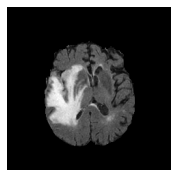

	Output of Transformer 1:


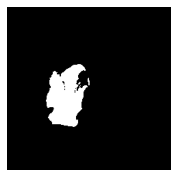

Evaluation 1:
	Output of Transformer 0:


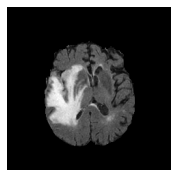

	Output of Transformer 1:


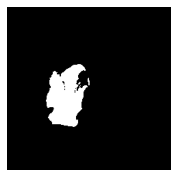

Evaluation 2:
	Output of Transformer 0:


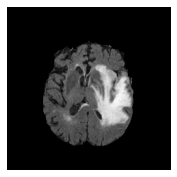

	Output of Transformer 1:


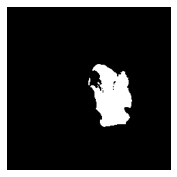

Evaluation 3:
	Output of Transformer 0:


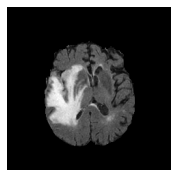

	Output of Transformer 1:


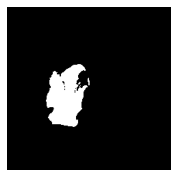

Generation stopped after n=4 evaluations


In [15]:
from deepvoxnet2.components.transformers import Split

x = Split(indices=(0,))(x_y)
y = Split(indices=(1,))(x_y)
x_y_creator = Creator(outputs=[x, y])
visualize_creator_outputs(x_y_creator, my_mirc_sampler[1])

Second, remember that we said that the input and output of a Transformer is a list of Sample objects.
In fact, this is only partly true and this has to do with the concept that a Transformer is applying the same random transformation to all Sample objects it can find at its input.
A Transformer can be connected to multiple inputs, resulting in multiple outputs, meaning that a Transformer may transformer multiple data pairs that are connected to the Transformer.
As such, we could have constructed the Transformer network from above in a many different ways.
Two possible alternatives are given below.

Alternative Transformer network A:
Evaluation 0:
	Output of Transformer 0:


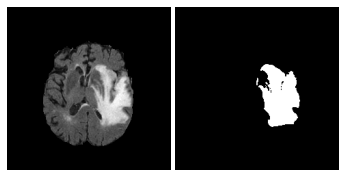

Evaluation 1:
	Output of Transformer 0:


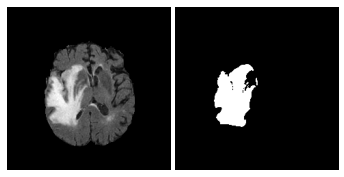

Evaluation 2:
	Output of Transformer 0:


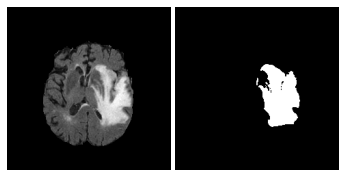

Evaluation 3:
	Output of Transformer 0:


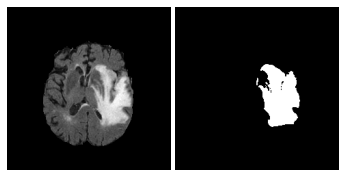

Generation stopped after n=4 evaluations

Alternative Transformer network B:
Evaluation 0:
	Output of Transformer 0:


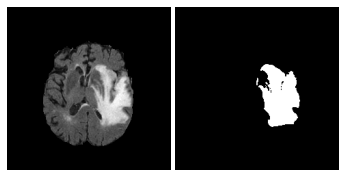

Evaluation 1:
	Output of Transformer 0:


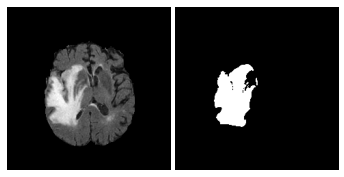

Evaluation 2:
	Output of Transformer 0:


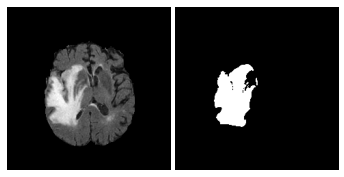

Evaluation 3:
	Output of Transformer 0:


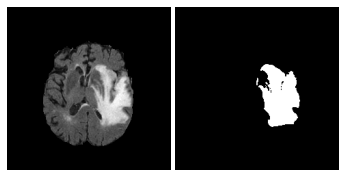

Generation stopped after n=4 evaluations


In [16]:
from deepvoxnet2.components.transformers import Group

print("Alternative Transformer network A:")
x_y = MircInput(["flair", "gt"], n=1, output_shapes=[(1, 240, 240, None, 1), (1, 240, 240, None, 1)])
x = Split(indices=(0,))(x_y)
y = Split(indices=(1,))(x_y)
flip_transformer = Flip(flip_probabilities=(0.5, 0, 0), n=4)
x = flip_transformer(x)
y = flip_transformer(y)
x_y = Group()([x, y])
x_y_creator = Creator(outputs=[x_y])
visualize_creator_outputs(x_y_creator, my_mirc_sampler[1])

print("\nAlternative Transformer network B:")
x = MircInput(["flair"], n=1, output_shapes=[(1, 240, 240, None, 1)])
y = MircInput(["gt"], n=1, output_shapes=[(1, 240, 240, None, 1)])
x, y = Flip(flip_probabilities=(0.5, 0, 0), n=4)(x, y)
x_y = Group()([x, y])
x_y_creator = Creator(outputs=[x_y])
visualize_creator_outputs(x_y_creator, my_mirc_sampler[1])

Third, some Transformer objects need a reference Transformer to calculate their internal transformation.
For example, if we want to produce some crops, we might want those to originate from non-zero portions of a certain Sample.
Similarly, if we want to deform the Samples using an affine transformation, we want to first compute the affine transform based on a reference Sample.
For this purpose it is always a good idea to have the reference output be a list of only one Sample, such that there is no ambiguity in which Sample is used as a reference.

Evaluation 0:
	Output of Transformer 0:


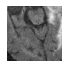

	Output of Transformer 1:


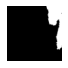

Evaluation 1:
	Output of Transformer 0:


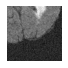

	Output of Transformer 1:


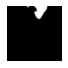

Evaluation 2:
	Output of Transformer 0:


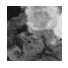

	Output of Transformer 1:


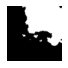

Evaluation 3:
	Output of Transformer 0:


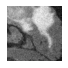

	Output of Transformer 1:


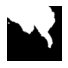

Evaluation 4:
	Output of Transformer 0:


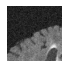

	Output of Transformer 1:


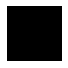

Evaluation 5:
	Output of Transformer 0:


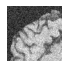

	Output of Transformer 1:


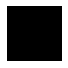

Evaluation 6:
	Output of Transformer 0:


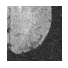

	Output of Transformer 1:


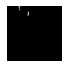

Evaluation 7:
	Output of Transformer 0:


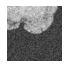

	Output of Transformer 1:


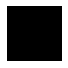

Evaluation 8:
	Output of Transformer 0:


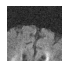

	Output of Transformer 1:


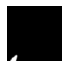

Evaluation 9:
	Output of Transformer 0:


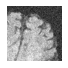

	Output of Transformer 1:


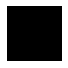

Evaluation 10:
	Output of Transformer 0:


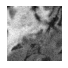

	Output of Transformer 1:


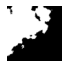

Evaluation 11:
	Output of Transformer 0:


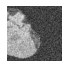

	Output of Transformer 1:


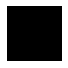

Evaluation 12:
	Output of Transformer 0:


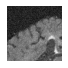

	Output of Transformer 1:


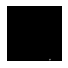

Evaluation 13:
	Output of Transformer 0:


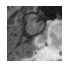

	Output of Transformer 1:


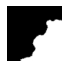

Evaluation 14:
	Output of Transformer 0:


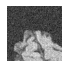

	Output of Transformer 1:


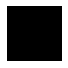

Evaluation 15:
	Output of Transformer 0:


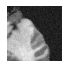

	Output of Transformer 1:


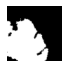

Generation stopped after n=16 evaluations


In [17]:
from deepvoxnet2.components.transformers import AffineDeformation, RandomCrop, GaussianNoise, Threshold

x = x_in = MircInput(["flair"], n=1, output_shapes=[(1, 240, 240, None, 1)])
y = MircInput(["gt"], n=1, output_shapes=[(1, 240, 240, None, 1)])
x, y = Flip(flip_probabilities=(0.5, 0, 0), n=4)(x, y)
x, y = AffineDeformation(x, rotation_window_width=(1, 0, 0), translation_window_width=(10, 10, 0), n=2)(x, y)
mask = Threshold(lower_threshold=0)(x)
x, y = RandomCrop(mask, (80, 80, 80), nonzero=True, n=2)(x, y)
x = GaussianNoise(mean=0, std=20)(x)
x_y_creator = Creator(outputs=[x, y])
visualize_creator_outputs(x_y_creator, my_mirc_sampler[1])

Again, notice how the above Transformer network is able to generate N=1\*4\*2\*2\*1\*1=16 transformed data pairs.
As soon as the network is getting more complex, it is always a good idea if the number generated corresponds to what you had in mind.
It is possible that an InputTransformer triggers to stop the generation too soon due to unwanted shortcuts in your network, e.g. your network contains parallel paths with one path generating more than the other.

Finally, the coolest thing about the Transformer network, is that it works with Sample objects, hence it always has notion of where the Sample is located in the *world*.
We could use the Put Transformer to *put back* all the image crops into a reference Sample space of choice.

Evaluation 0:
	Output of Transformer 0:


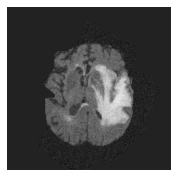

Generation stopped after n=1 evaluations


In [18]:
from deepvoxnet2.components.transformers import Buffer, Put

x_buffered = Buffer(buffer_size=None)(x)
x_put_back = Put(reference_connection=x_in)(x_buffered)
x_creator = Creator(outputs=[x_put_back])
visualize_creator_outputs(x_creator, my_mirc_sampler[1])

# 6. DVN2 for CNN-based applications
At this point we can generate, albeit still implicitly, a wide variety of sets, e.g. $\mathcal{S''}$, starting from the set $S'$.
Using the suggested DVN2 way, we could operate as follows:
- organize the set of data pairs $\mathcal{S'}$ as Record objects in a Mirc object;
- create a MircSampler from the Mirc object to sample MircIdentifiers;
- make a Transformer network (as a Creator) that starts from a MircIdentifier and generates new data pairs.

As a result, we have a powerful tool at our disposal that we can use to make CNN-based application pipelines.
In order to effectively use it, in DVN2 we made the link with the Tensorflow library, in particular Keras.
Nevertheless, up till this point everything was coded in Python in a way that is independent of the deep learning framework.
When desired, the following functions can be adapted to be used with other deep learning frameworks such as Pytorch.

## 6.1 Tensorflow Dataset wrapper
The Tensorflow Dataset is another representation for a set of data pairs.
The combination of a Creator and a Sampler has all information that is necessary to construct a Tensorflow Dataset.

In [19]:
import time
from deepvoxnet2.components.model import TfDataset

my_tf_dataset = TfDataset(x_y_creator, my_mirc_sampler, batch_size=1)
count = 0
prev_time = time.time()
for element in my_tf_dataset:
    print("Generation took {:.2f} s".format(time.time() - prev_time), [[sample.shape for sample in transformer_output] for transformer_output in element])
    count += 1
    prev_time = time.time()

print(f"The entire dataset contains {count} elements")

2022-04-29 18:10:29.733545: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-29 18:10:29.838540: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f90a7d4fc70 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-04-29 18:10:29.838550: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


Generation took 13.23 s [[TensorShape([1, 80, 80, 80, 1])], [TensorShape([1, 80, 80, 80, 1])]]
Generation took 0.00 s [[TensorShape([1, 80, 80, 80, 1])], [TensorShape([1, 80, 80, 80, 1])]]
Generation took 0.00 s [[TensorShape([1, 80, 80, 80, 1])], [TensorShape([1, 80, 80, 80, 1])]]
Generation took 0.00 s [[TensorShape([1, 80, 80, 80, 1])], [TensorShape([1, 80, 80, 80, 1])]]
Generation took 0.00 s [[TensorShape([1, 80, 80, 80, 1])], [TensorShape([1, 80, 80, 80, 1])]]
Generation took 0.00 s [[TensorShape([1, 80, 80, 80, 1])], [TensorShape([1, 80, 80, 80, 1])]]
Generation took 0.00 s [[TensorShape([1, 80, 80, 80, 1])], [TensorShape([1, 80, 80, 80, 1])]]
Generation took 0.00 s [[TensorShape([1, 80, 80, 80, 1])], [TensorShape([1, 80, 80, 80, 1])]]
Generation took 0.00 s [[TensorShape([1, 80, 80, 80, 1])], [TensorShape([1, 80, 80, 80, 1])]]
Generation took 0.00 s [[TensorShape([1, 80, 80, 80, 1])], [TensorShape([1, 80, 80, 80, 1])]]
Generation took 0.00 s [[TensorShape([1, 80, 80, 80, 1])], 

Using the standard options, it iterates through *my_mirc_sampler* only once.
Before going to the next Identifier in the Sampler, it will ask the underlying Transformer network in the Creator to run until completion.
This is the reason why a total of N=10\*16 elements were produced, and that it seemed to go in blocks of 16.
Looking at the structure and shape of an element, this is exactly what we would expect from our *x_y_creator*.
We could use this dataset to train the CNN.
Using a batch size of 1, there would be 160 updates per epoch, which we could define here as one loop through the entire new set of transformed data pairs.
In order to better shuffle across subjects (Identifiers actually) and make the generation quicker, we could play around with some options.

In [20]:
my_tf_dataset = TfDataset(x_y_creator, my_mirc_sampler, batch_size=4, shuffle_samples=64, prefetch_size=64)
count = 0
prev_time = time.time()
for element in my_tf_dataset:
    print("Generation took {:.2f} s".format(time.time() - prev_time), [[sample.shape for sample in transformer_output] for transformer_output in element])
    count += 1
    prev_time = time.time()

print(f"The entire dataset contains {count} elements")

2022-04-29 18:12:32.771492: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:172] Filling up shuffle buffer (this may take a while): 17 of 64
2022-04-29 18:12:42.179343: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:172] Filling up shuffle buffer (this may take a while): 33 of 64
2022-04-29 18:12:51.652295: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:172] Filling up shuffle buffer (this may take a while): 49 of 64
2022-04-29 18:12:51.663972: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:221] Shuffle buffer filled.


Generation took 46.47 s [[TensorShape([4, 80, 80, 80, 1])], [TensorShape([4, 80, 80, 80, 1])]]
Generation took 0.00 s [[TensorShape([4, 80, 80, 80, 1])], [TensorShape([4, 80, 80, 80, 1])]]
Generation took 0.01 s [[TensorShape([4, 80, 80, 80, 1])], [TensorShape([4, 80, 80, 80, 1])]]
Generation took 0.01 s [[TensorShape([4, 80, 80, 80, 1])], [TensorShape([4, 80, 80, 80, 1])]]
Generation took 8.23 s [[TensorShape([4, 80, 80, 80, 1])], [TensorShape([4, 80, 80, 80, 1])]]
Generation took 0.01 s [[TensorShape([4, 80, 80, 80, 1])], [TensorShape([4, 80, 80, 80, 1])]]
Generation took 0.01 s [[TensorShape([4, 80, 80, 80, 1])], [TensorShape([4, 80, 80, 80, 1])]]
Generation took 0.01 s [[TensorShape([4, 80, 80, 80, 1])], [TensorShape([4, 80, 80, 80, 1])]]
Generation took 8.94 s [[TensorShape([4, 80, 80, 80, 1])], [TensorShape([4, 80, 80, 80, 1])]]
Generation took 0.00 s [[TensorShape([4, 80, 80, 80, 1])], [TensorShape([4, 80, 80, 80, 1])]]
Generation took 0.01 s [[TensorShape([4, 80, 80, 80, 1])], 

## 6.2 CNN architectures

In [21]:
from deepvoxnet2.keras.models.unet_generalized_v2 import create_generalized_unet_v2_model
# from deepvoxnet2.keras.models.deepmedic_generalized_v2 import create_generalized_deepmedic_v2_model

unet_model = create_generalized_unet_v2_model(number_input_features=1, output_size=(80, 80, 80))
# deepmedic_model = create_generalized_deepmedic_v2_model(number_input_features_per_pathway=(1, 1))

/Users/jberte3/opt/anaconda3/envs/deepvoxnet2/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.4.0 and strictly below 2.7.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.3.4 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(



field of view:	[185, 185, 185]	(theoretical)
output size:	[80, 80, 80]	(user defined)
input size:	[264, 264, 264]	(inferred with theoretical field of view (less meaningful if padding='same'))
input size:	[80, 80, 80]	(true input size of the network)

possible output sizes:
x: [16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192, 208, 224, 240, 256, 272, 288, 304, 320, 336, 352, 368, 384, 400, 416, 432, 448, 464, 480, 496]
y: [16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192, 208, 224, 240, 256, 272, 288, 304, 320, 336, 352, 368, 384, 400, 416, 432, 448, 464, 480, 496]
z: [16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192, 208, 224, 240, 256, 272, 288, 304, 320, 336, 352, 368, 384, 400, 416, 432, 448, 464, 480, 496]

possible input sizes (corresponding with the possible output sizes):
x: [16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192, 208, 224, 240, 256, 272, 288, 304, 320, 336, 352, 368, 384, 400, 416, 432, 448, 464, 480, 496]
y: [16, 32, 48, 64, 80, 96, 112, 128, 144, 

## 6.3 Training a CNN

In [ ]:
from deepvoxnet2.keras.optimizers import SGD
from deepvoxnet2.keras.losses import get_loss

unet_model.compile(optimizer=SGD(learning_rate=1e-3, momentum=0.9, nesterov=True), loss=get_loss("dice_loss", reduce_along_batch=True))
unet_model.fit(my_tf_dataset, epochs=1)

2022-04-29 18:14:10.477809: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:172] Filling up shuffle buffer (this may take a while): 17 of 64
2022-04-29 18:14:19.631777: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:172] Filling up shuffle buffer (this may take a while): 33 of 64
2022-04-29 18:14:28.523736: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:172] Filling up shuffle buffer (this may take a while): 49 of 64
2022-04-29 18:14:28.536970: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:221] Shuffle buffer filled.


     21/Unknown - 1017s 48s/step - loss: 0.9530

# 7. The DVN Model [under construction]
Mention very clearly that training and inference sets may be different in terms of what a data pair contains.
But this does not matter because we have simply formalized a data pair as a record or a list of Sample object.
Thus this could well be a Record or a list with only input data.
Just make sure that your Creator or Transformers are build correctly such that the test key can handle unknown data.

# 8. Other functionalities in DVN2
The main contribution of DVN2 is clearly the intuitive way of implementing preprocessing, sampling an postprocessing, and providing a way to store everything under one single object.
However, there are other unexplored fruits available.

## 8.1 Utilities
Under ```deepvoxnet.utilities``` there are many useful utility functions available:
- **conversions.py**
Here you can find many useful loading and conversion functions.
For example, reading a Dicom file (including time series such as CT perfusion data) from disk, conversions between Nifti, SimpleITK and Dicom.
- **transformations.py**
Perfect for doing resampling, registration, etc, mainly starting from Nifti files.
This is unlike many other libraries that require SimpleITK file formats or you need to use via the Terminal.
- **drawing.py**
Some cool functions to draw overlays.

## 8.2 Analysis
Under ```deepvoxnet.analysis``` we can find several handy tools to:
- **data.py**
The Data class can be viewed as a single-column Pandas Dataframe with additional functionalities, specifically to work with data that has MultiIndex strucutre as Dataset>Case>Record.
We could group or compute statistics across either of these indices.
- **analysis.py**
The Analysis class can be viewed as a multi-column Pandas Dataframe with additional functionalities.
For example, when having two columns, we can apply a metric function to each row, such that a Data object is returned.
- **plotting.py**
This library uses the Figure class for plotting such that you can draw figures using an absolute scale.
Furthermore, since typical plotting libraries cannot handle NaNs, we have the Series, SeriesGroup and GroupedSeries objects that compute statistics and can be used to plot, even if they contain NaNs.